<a href="https://colab.research.google.com/github/jx-dohwan/Aiffel_EGLMS_Project/blob/main/%5BExp_6%5DWriting_lyrics(NLP).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Exp_6]Writing_lyrics(NLP)

## 1. 라이브러리 버전 확인 및 import

In [1]:
import tensorflow as tf
import glob
import re
import numpy as np
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import GridSearchCV, train_test_split


print(tf.__version__)

2.8.2


## 2. 데이터 읽어오기

In [2]:
txt_file_path = "/content/drive/MyDrive/인공지능/아이펠/ES/data/lyrics/*"

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus에 담는다.
for txt_file in txt_list:
  with open(txt_file, "r") as f:
    raw = f.read().splitlines()
    raw_corpus.extend(raw)

print('데이터 크기 : ', len(raw_corpus))
print('Examples : \n', raw_corpus[:3])

데이터 크기 :  227088
Examples : 
 ['The first words that come out', 'And I can see this song will be about you', "I can't believe that I can breathe without you"]


## 3. 데이터 정제

앞서 배운 테크닉들을 활용해 문장 생성에 적합한 모양새로 데이터를 정제하세요!

preprocess_sentence() 함수를 만든 것을 기억하시죠? 이를 활용해 데이터를 정제하도록 하겠습니다.

추가로 지나치게 긴 문장은 다른 데이터들이 과도한 Padding을 갖게 하므로 제거합니다. 너무 긴 문장은 노래 가사 작사하기에 어울리지 않을 수도 있겠죠.
그래서 이번에는 문장을 토큰화 했을 때 토큰의 개수가 15개를 넘어가는 문장을 학습 데이터에서 제외하기 를 권합니다.

In [3]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

print(preprocess_sentence("This @_is ;;;sample        sentence."))

# regexr 참고
# 정규표현식을 더 추가하거나 빼거나 수정할 수 있다. 

<start> this is sample sentence . <end>


In [4]:
# 여기에 정제된 문장을 모을겁니다
corpus = []

for sentence in raw_corpus:
  if len(sentence) == 0: continue
  if sentence[-1] == ":": continue # 데이터를 확인해본결과 셰익스피어 파일도 있기 때문에 이것도 넣어 주었다.
  
    # 정제를 하고 담아주세요
  preprocessed_sentence = preprocess_sentence(sentence)
  corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인해보죠
corpus[:20]



['<start> the first words that come out <end>',
 '<start> and i can see this song will be about you <end>',
 '<start> i can t believe that i can breathe without you <end>',
 '<start> but all i need to do is carry on <end>',
 '<start> the next line i write down <end>',
 '<start> and there s a tear that falls between the pages <end>',
 '<start> i know that pain s supposed to heal in stages <end>',
 '<start> but it depends which one i m standing on i write lines down , then rip them up <end>',
 '<start> describing love can t be this tough i could set this song on fire , send it up in smoke <end>',
 '<start> i could throw it in the river and watch it sink in slowly <end>',
 '<start> tie the pages to a plane and send it to the moon <end>',
 '<start> play it for the world , but it won t mean much <end>',
 '<start> unless i sing this song to you i m dying to show you <end>',
 '<start> this could end happily ever after <end>',
 '<start> there doesn t ever have to be disaster <end>',
 '<start> 

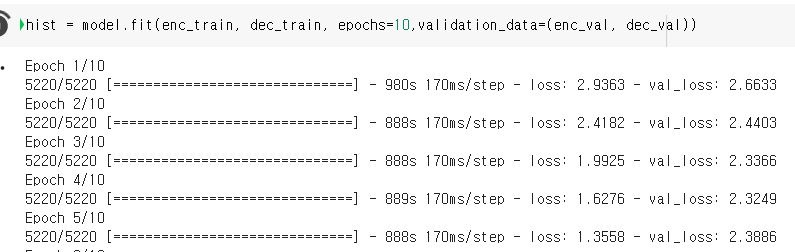

-  공백인 문장을 지웠으나 오히려 val_loss의 값이 오른 것을 확인할 수 있다.

- 단어하나?? 두개 있는거 필요없으면 지우기"

In [5]:
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다
# 더 잘 알기 위해 아래 문서들을 참고하면 좋습니다
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
def tokenize(corpus):
    # 7000단어를 기억할 수 있는 tokenizer를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 7000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post',maxlen=21) # maxlen을 15로 권장해서 15
    print(tensor,tokenizer)
    
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2    6  237 ...    0    0    0]
 [   2    8    5 ...    0    0    0]
 [   2    5   38 ...    0    0    0]
 ...
 [   2  848    1 ...    0    0    0]
 [   2  161   64 ...    0    0    0]
 [   2 4396  161 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7fcf5970d7d0>


In [6]:
print(tensor)

[[   2    6  237 ...    0    0    0]
 [   2    8    5 ...    0    0    0]
 [   2    5   38 ...    0    0    0]
 ...
 [   2  848    1 ...    0    0    0]
 [   2  161   64 ...    0    0    0]
 [   2 4396  161 ...    0    0    0]]


In [7]:
print(tensor)

[[   2    6  237 ...    0    0    0]
 [   2    8    5 ...    0    0    0]
 [   2    5   38 ...    0    0    0]
 ...
 [   2  848    1 ...    0    0    0]
 [   2  161   64 ...    0    0    0]
 [   2 4396  161 ...    0    0    0]]


In [8]:
# index_word_sorted = sorted(index_word.items(), key = lambda x:x[1], reverse = True)
# print(index_word_sorted)

## 4. 평가 데이터셋 분리

훈련 데이터와 평가 데이터를 분리하세요!

tokenize() 함수로 데이터를 Tensor로 변환한 후, sklearn 모듈의 train_test_split() 함수를 사용해 훈련 데이터와 평가 데이터를 분리하도록 하겠습니다. 단어장의 크기는 12,000 이상 으로 설정하세요! 총 데이터의 20% 를 평가 데이터셋으로 사용해 주세요!

In [9]:
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[1])
print(tgt_input[1])

[  2   8   5  38  69  34 372  77  27 122   7   3   0   0   0   0   0   0
   0   0]
[  8   5  38  69  34 372  77  27 122   7   3   0   0   0   0   0   0   0
   0   0]


In [10]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size=0.2, random_state=23 )

## 5.인공지능 만들기

In [11]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [12]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model.compile(loss=loss, optimizer=optimizer)

In [13]:
hist = model.fit(enc_train, dec_train, epochs=10,validation_data=(enc_val, dec_val),batch_size=128)

Epoch 1/10
1249/1249 [==============================] - 107s 81ms/step - loss: 2.6418 - val_loss: 2.4032
Epoch 2/10
1249/1249 [==============================] - 101s 81ms/step - loss: 2.3087 - val_loss: 2.2478
Epoch 3/10
1249/1249 [==============================] - 101s 81ms/step - loss: 2.1601 - val_loss: 2.1557
Epoch 4/10
1249/1249 [==============================] - 101s 81ms/step - loss: 2.0421 - val_loss: 2.0906
Epoch 5/10
1249/1249 [==============================] - 101s 81ms/step - loss: 1.9374 - val_loss: 2.0437
Epoch 6/10
1249/1249 [==============================] - 101s 81ms/step - loss: 1.8410 - val_loss: 2.0111
Epoch 7/10
1249/1249 [==============================] - 101s 81ms/step - loss: 1.7509 - val_loss: 1.9890
Epoch 8/10
1249/1249 [==============================] - 101s 81ms/step - loss: 1.6663 - val_loss: 1.9746
Epoch 9/10
1249/1249 [==============================] - 101s 81ms/step - loss: 1.5868 - val_loss: 1.9638
Epoch 10/10
1249/1249 [==============================] 

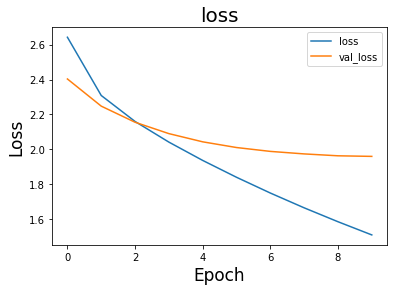

In [14]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('loss',fontsize=20)
plt.xlabel('Epoch', fontsize=17)
plt.ylabel('Loss',fontsize=17)
plt.legend(['loss', 'val_loss'], loc='upper right')

plt.show()

In [15]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [16]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you so much , i love you so much <end> '

## 회고

- 시도해본 것
  - LMS에 있는 데이터셋 객체를 생성하는 코드를 적용하여 train_dataset과 test_dataset을 만들어서 학습을 시켰으나 val_loss가 5점대로 올라갔고 학습을 할때마다 더 올라간 것을 확인할 수 있었다

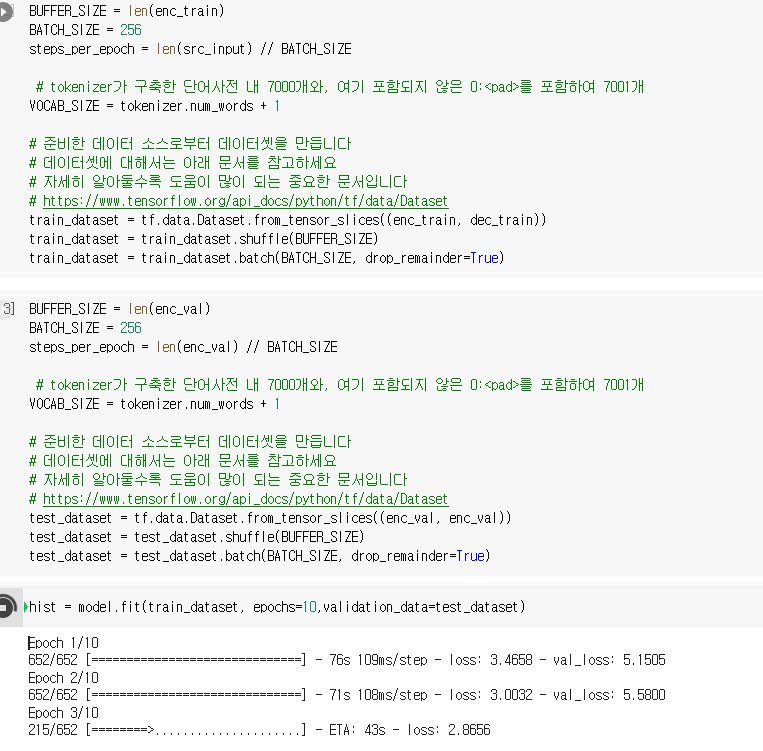

  - 음악 가사 이기 때문에 LMS에 있는  if sentence[-1] == ":": continue 코드를 지우고 사용하였지만 이번 데이터셋에도 셰익스피어 파일이 있는 것을 확인하여 다시 이 코드를 적용시켰다.
  - 문장 길이를 15개로 권장하여서 15개로 계속 시도해보았으니 val_loss가 2.2017이 최솟값이고 더이상 떨어지지 않는 것을 확인할 수 있었다. 그래서 어차피 마지막에 길이가 20인 문장을 출력하고 있으니 paading에서 maxlen을 21로 지정하여 20개의 문장으로 학습을 진행하였다.
  - embedding_size와 hidden_size를 4096까지 올려 val_loss를 낮추려고 시도해보았으나 2.2017이 최소이며 사용하는 문장길이를 21로 늘려주니 금방 val_loss를 맞출 수 있었다. 그래서 LMS상인 embedding_size = 256, hidden_size=1024로 맞추어서 다시 학습을 진행하였다.
  - batch_size를 조정하여 데이터를 나누어주어 학습 속도를 올릴 수 있었다.
  - 여러 시도를 많이 했지만 코드에 남는건 별로 없어서 아쉽다. 